### Theory

#### Hypothesis Testing – The problem of multiple comparisons [5 points]

##### Question A
On the first experiment ($m = 1$) the chance that the results are significant given that the experiment lacks the power to reject is equal to $\alpha$. On the second experiment it is equal to $\alpha * P(\text{We didn't reject experiment } m-1)$. So

$$P(m^{th} \text{ experiment is significant | } m \text{ experiments lacking power to reject } H_0) = (1 - \alpha)^{m-1} * \alpha$$

Example:

$\alpha = 0.05$

$m = 6$

$P(6^{th} \text{ experiment is significant | } 6 \text{ experiments lacking power to reject } H_0) = (1-0.05)^{6-1}*0.05 \approx 0.038$

#### Question B

There is an increased chance of finding at least one false significant finding the more tests you perform. If m independent comparisons are performed, the family wise error rate (FWER) can be used. The formula for the FWER is the following:

$$\alpha_{fw} = 1-(1-\alpha)^{m}$$

so

$$P(\text{ at least one significant result | } m \text{ experiments lacking power to reject } H_0) = \alpha_{fw}$$

To arrive at this result, observe that this is $1 - P(m \text{ insignificant results | } m \text{ experiments lacking power to reject } H_0)$

Example:

$\alpha = 0.05$

$m = 6$

$\alpha_{fw} = 1-(1-0.05)^6\approx0.26$

#### Bias and unfairness in Interleaving experiments [10 points]
Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning ⅔ of the time, even though in theory the percentage of wins should be 50% for both algorithms. Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?

Ranking P

| D1 N |<br>
| D2 N |<br>
| D3 R |<br>

Ranking E

| D2 N |<br>
| D3 R |<br>
| D1 N |<br>

Because D3 is the only relevant document, we'd expect it's clicks to be attributed to E more often than to P.

The set of possible interleaved rankings using Team-Draft Interleaving is as follows:

| D1 N (P) | &emsp; | D1 N (P) | &emsp; | D2 N (E) | &emsp; | D2 N (E) | <br>
| D2 N (E) | &emsp; | D2 N (E) | &emsp; | D1 N (P) | &emsp; | D1 N (P) | <br>
| D3 R (P) | &emsp; | D3 R (E) | &emsp; | D3 R (P) | &emsp; | D3 R (E) | <br>

Where D3 is in the same position in all rankings, with equal assignments to P and E. Thus, in this case, the expected number of clicks is the same for both ranking functions even though ranking E should win. This is an example of insensitivy to the quality of rankings.

Example is based on: Hofmann, K., Whiteson, S., & De Rijke, M. (2011, October). A probabilistic method for inferring preferences from clicks. In Proceedings of the 20th ACM international conference on Information and knowledge management (pp. 249-258). ACM.

### Step 1: Simulate Rankings of Relevance for E and P 

In [254]:
'''generate all combinations of all permuations of the relevance labels 'N', 'R' and 'HR'.'''

import itertools
import numpy as np

# Added the numbers to facilitate easy sorting.
REL_SCORES = {'N' : 0, 'R' : 1, 'HR' : 2}

# Generate all possible rankings for both Production and Experimental systems
P = list(itertools.product(REL_SCORES.keys(), repeat = 5))
E = list(itertools.product(REL_SCORES.keys(), repeat = 5))

# Generate all combinations of the permutations 
rankings = list(itertools.product(P, E))

# Example of the generated rankings
for p, e in rankings[0::10000]:
    print(p)
    print(e)
    print()

('N', 'N', 'N', 'N', 'N')
('N', 'N', 'N', 'N', 'N')

('N', 'R', 'R', 'R', 'HR')
('N', 'R', 'R', 'N', 'R')

('R', 'N', 'N', 'N', 'R')
('N', 'HR', 'HR', 'N', 'HR')

('R', 'R', 'R', 'HR', 'N')
('R', 'R', 'N', 'R', 'N')

('HR', 'N', 'N', 'N', 'HR')
('R', 'HR', 'R', 'R', 'R')

('HR', 'R', 'R', 'HR', 'R')
('HR', 'N', 'HR', 'R', 'HR')



### Step 2: Implement Evaluation Measures

The evaluation measures used for offline evaluation are:

* Precision at k
* nDCG at k
* Expected Reciprocal Rank

In [255]:
'''These are the function definitions for the methods to calculate the evaluation measures'''

def precision_at_k(ranking, k):
    subset = ranking[:k]
    n_relevant = 0
    
    for result in subset:
        if REL_SCORES[result] > 0:
            n_relevant += 1
    
    return n_relevant / k

def DCG_at_k(ranking, k, optimal=False):
    subset = ranking[:k]
    
    # Optionally sort the ranking to calculate the maximum possible score
    if optimal:
        subset = sorted(subset, reverse=True, key=lambda x: REL_SCORES[x])
        
    discounted_score = 0
    
    for i, result in enumerate(subset):
        # prepare variables for DCG formula
        rank = i + 1
        rel = REL_SCORES[result]
        
        # Calculate score
        score = (2**rel - 1) / np.log2(1 + rank)
        discounted_score += score
    
    # NB: sum is built into the for-loop
    return discounted_score
        
def nDCG_at_k(ranking, k):
    true = DCG_at_k(ranking, k)
    best = DCG_at_k(ranking, k, optimal=True)
    
    # This is to prevent dividing by 0. If the best possible DCG is 0, the
    # true DCG is also zero (because there are no relevant document is the top k)
    if best == 0.0: 
        return 0.0
    else:
        return true / best

def prob_of_relevance(grade, max_grade):
    return (2**grade - 1) / 2**max_grade

def ERR(ranking):
    """Algorithm to compute ERR in linear time, implemented based on 
    
    Chapelle, O., Metlzer, D., Zhang, Y., & Grinspan, P. (2009, November). 
    Expected reciprocal rank for graded relevance. In Proceedings of the 18th ACM conference
    on Information and knowledge management (pp. 621-630). ACM."""
    
    grades = [REL_SCORES[x] for x in ranking]
    max_grade = max(REL_SCORES.values())
    
    p = 1
    err = 0
    
    for r in range(len(grades)):
        R = prob_of_relevance(grades[r], max_grade)
        err += p * (R/(r+1))
        p *= (1 - R)
    
    return err

In [256]:
'''The following loop calculates the precision, nDCG and ERR values for all simulated ranking.

It has been said during the lectures that a user often only looks at the top results,
and that k = 3 is a reasonable depth for the evaluation.'''

depth = 3

precision_p = []
precision_e = []
dcg_p = []
dcg_e = []
err_p = []
err_e = []

for i, (p, e) in enumerate(list(rankings)):
    precision_p.append(precision_at_k(p, depth))
    precision_e.append(precision_at_k(e, depth))

    dcg_p.append(nDCG_at_k(p, depth))
    dcg_e.append(nDCG_at_k(e, depth))
    
    err_p.append(ERR(p))
    err_e.append(ERR(e))

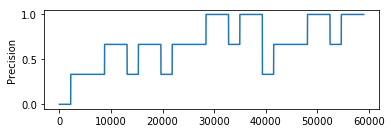

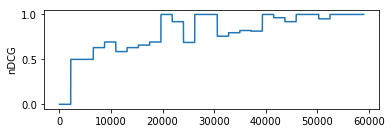

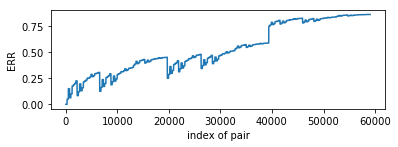

In [257]:
'''To have some idea about the range of the values of these measures, we plot the results 
of the production model'''

import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(range(len(precision_p)), precision_p)
plt.ylabel("Precision")

plt.figure(2)
plt.subplot(211)
plt.plot(range(len(dcg_p)), dcg_p)
plt.ylabel("nDCG")

fig = plt.figure(3)
plt.subplot(211)
plt.plot(range(len(err_p)), err_p)
plt.ylabel("ERR")
plt.xlabel("index of pair")

plt.show()

### Step 3: Calculate the 𝛥measure

We compare the measures for each ranking pair by calculating the difference of the experimental model and the production model. With those numbers a percentage can be calculated of the fraction of wins for model E.

In the assignment is says to only consider pairs for which E > P. But we found it easier to keep
all pairs, because we have to compare the results with the online rankings. If we discard some pairs,
the arrays don't line up anymore.

In [258]:
def delta_measure(scores_a, scores_b):
    return [b - a for a, b in zip(scores_a, scores_b)]

def percentage_of_wins_for_E(delta_values):
    return np.sum(np.array(delta_values) > 0) / len(delta_values)

# Calculate delta measure for the three chosen metrics
delta_precision = delta_measure(precision_p, precision_e)
delta_nDCG = delta_measure(dcg_p, dcg_e)
delta_ERR = delta_measure(err_p, err_e)

print("A subset of delta precisions: \n{}".format(delta_precision[0::10000]))
print("percentage of wins for E:\n", percentage_of_wins_for_E(delta_precision))
print()
print()
print("A subset of delta nDCGs \n{}".format(delta_nDCG[0::10000]))
print("Percentage of wins for E:\n", percentage_of_wins_for_E(delta_nDCG))
print()
print()
print("A subset of delta ERRs \n{}".format(delta_ERR[0::10000]))
print("Percentage of wins for E:\n", percentage_of_wins_for_E(delta_ERR))

A subset of delta precisions: 
[0.0, 0.0, 0.3333333333333333, -0.33333333333333337, 0.6666666666666667, -0.33333333333333337]
percentage of wins for E:
 0.331961591221


A subset of delta nDCGs 
[0.0, 0.0, -0.30657359638272919, 0.0, -0.17868628538621723, -0.080279210851812444]
Percentage of wins for E:
 0.427983539095


A subset of delta ERRs 
[0.0, -0.0703125, 0.15937500000000004, -0.0908203125, -0.2265625, -0.0015624999999999112]
Percentage of wins for E:
 0.497366593846


### Step 4:  Implement Interleaving

For this step, we ended up implementing both Balanced and Team-Draft interleaving. 

In [259]:
'''Here are the function definitions of the two interleaving algorithms'''

import random

# Use a seed to ensure the tests can be replicated
random.seed(100)

def balanced_interleaving(A,B):

    # initialize pointers p_a and p_b
    p_a, p_b, I = 0, 0, []

    # Flip a coin to decide which pointer to pick highest value from ranking
    turn = 'A' if random.randint(0, 1) == 0 else 'B'

    # Greedily collect rankings from both lists and build the interleaved list,
    # while there are still documents not present in the interleaved list
    while p_a < len(A) and p_b < len(B):
        if p_a < p_b or p_a == p_b and turn == 'A':
            if A[p_a] not in I:
                I.append(A[p_a])
            p_a += 1
        else:
            if B[p_b] not in I:
                I.append(B[p_b])
            p_b += 1
    return(I[:5])

def team_draft_interleaving(A,B):
    # create teams
    team_a, team_b, I = 0, 0, []
    
    # While there are still documents not present in the interleaved list
    while any(set(A)-set(I)) and any(set(B)-set(I)):
        
        #Flip a coin
        turn = 'A' if random.randint(0, 1) == 0 else 'B'
        
        #If A wins the coin flip: put the highest ranked document of A
        # that is not yet in the interleaved list, in the interleaved
        if team_a < team_b or team_a == team_b and turn == 'A':
            for a in A:
                if a not in I:
                    I.append(a)
                    break
            team_a += 1
        # If B wins the flip: put the highest ranked document of A
        # that is not yet in the interleaved list, in the interleaved
        else:
            for b in B:
                if b not in I:
                    I.append(b)
                    break
            team_b += 1
    return(I[:5])

In [260]:
'''Genererates interleaved versions of all ranking pairs'''

balanced_interleaved_lists = []
team_interleaved_lists = []

for A,B in rankings:
    
    # Create a unique string for each document based on its position, the model that generated it
    # and its relevance label
    A, B = [str(a) + "P" + str(i) for i, a in enumerate(A)], [str(b) + "E" + str(i) for i, b in enumerate(B)]
    
    interleaved_list_balanced = balanced_interleaving(A,B)
    interleaved_list_team = team_draft_interleaving(A,B)
    
    balanced_interleaved_lists.append(interleaved_list_balanced)
    team_interleaved_lists.append(interleaved_list_team)

print('Example of the balanced interleaved lists:')
for balanced in balanced_interleaved_lists[::10000]:
    print(balanced)

print()

print('Example of the balanced interleaved lists:')
for team in team_interleaved_lists[::10000]:
    print(team)

Example of the balanced interleaved lists:
['NP0', 'NE0', 'NP1', 'NE1', 'NP2']
['NP0', 'NE0', 'RP1', 'RE1', 'RP2']
['NE0', 'RP0', 'HRE1', 'NP1', 'HRE2']
['RP0', 'RE0', 'RP1', 'RE1', 'RP2']
['HRP0', 'RE0', 'NP1', 'HRE1', 'NP2']
['HRE0', 'HRP0', 'NE1', 'RP1', 'HRE2']

Example of the balanced interleaved lists:
['NE0', 'NP0', 'NP1', 'NE1', 'NE2']
['NE0', 'NP0', 'RP1', 'RE1', 'RE2']
['RP0', 'NE0', 'HRE1', 'NP1', 'HRE2']
['RP0', 'RE0', 'RE1', 'RP1', 'NE2']
['RE0', 'HRP0', 'NP1', 'HRE1', 'RE2']
['HRE0', 'HRP0', 'RP1', 'NE1', 'HRE2']


### Step 5:  Implement User Clicks Simulation

In [261]:
''' In this cell the Random click model is implemented. We use the PyClick module to parse the Yandex file.
Our TA assured us it is fine, if we use it just for the parsing of the Yandex file.
Furthermore we assume all queries should be used, even if none of the results are clicked'''

def execute_clicks(click_probs):
    """Returns a list of booleans indicating on which positions was clicked, based on the
    given click_probs (click probabilities)"""
    
    # Flip one coin for (and with) every probability in click_probs
    return np.random.binomial(1, p=click_probs)

def MLE_random_click(sessions):
    '''As slide 62 of lecture 3 shows, the MLE of a bernouilli distribution, rho, is just
    the ratio of clicks with respect to the total number of URls shown. 
    '''
    total_clicks = 0
    total_shown = len(sessions)*10
    
    for sesh in sessions:
        total_clicks += sum(sesh.get_clicks())
    
    rho = total_clicks/total_shown
    return rho
            
def random_click_probabilities(ranking, rho):
    '''probabilities of a click from the random clicking model'''
    return [rho] * len(ranking)

def simulate_random_click_model(ranking, rho, N):
    '''Generate N click patterns based on the random click model'''
    return [execute_clicks(random_click_probabilities(ranking, rho)) for _ in range(N)]

def sdbn_click_probabilities(ranking, alphas, sigmas):
    '''Probabilities of a click from the Simple Bayesian Dynamic Network'''
    
    # Assume zero probabilities
    click_probs = [0.0] * len(ranking)
    
    for i, relevance in enumerate(ranking):
        
        # Click when attracted
        alpha = alphas[relevance[:-2]]
        click_probs[i] = alpha
        
        # If satisfied, we do not evaluate the rest of the documents
        satisfied = float(np.random.choice([0,1], 1, p=[(1-sigmas[i]),(sigmas[i])]))
        if satisfied:
            break
    
    return click_probs

def simulate_sdbn_click_model(ranking, alphas, sigmas, N):
    '''Generate N click patterns based on the SDBN click model'''
    return [execute_clicks(sdbn_click_probabilities(ranking, alphas, sigmas)) for _ in range(N)]

In [262]:
'''We use the pyclick to interface with the dataset. We are aware that there are out-of-box
click models available in the package but we don't use those. We've checked this with our TA
and using it for this purpose was '''

import pyclick
from pyclick.utils import YandexRelPredChallengeParser

parser = YandexRelPredChallengeParser.YandexRelPredChallengeParser()
search_sessions = parser.parse('YandexRelPredChallenge.txt')

## Our method of estimating sigmas for SDBN

For the Simple Dynamic Bayesian Network click model we learn the satisfaction parameter $\sigma_{u_rq}$, meaning we learn the satisfaction for each query and the document ID that was clicked last. The Maximum Likelihood estimation for the satisfaction becomes: 

<center>
    
$\sigma_{u_rq} = \frac{l_{u_rq}}{T_{u_rq}}$, 
</center>

where $l_{u_rq}$ is the count of events the document ID was clicked last given the query and $T_{u_rq}$ represents the total number of times the document ID was clicked for the query.

We are assuming that the document IDs are ranked deterministically, meaning that the query will always output the same 10 document IDs in the same order. This assumption allows us to discard the document ID information, and instead keep rank indication of a click given the query.

The resulting matrix consists of n-queries by 10-ranks, where each element carries the satisfaction parameter of a rank given the query. As query-rank satisfaction parameters are not useful to our relevance rankings, we need to estimate a general satisfaction parameter for each rank. We do this by calculating the mean of satisfaction parameters for all queries given a rank. This leaves us with a 1 by 10 vector; an average satisfaction parameter per rank.

In [263]:
# Assumption: query always returns the same docIDs (ie. ranking is deterministic)

from collections import Counter

def learn_sdbn_satisfaction(search_sessions):
    last_click_ranks = dict()
    clicks_per_query = dict()
    last_total_ratio = dict()

    # Find last click rank per query:
    for session in search_sessions:
        
        # If get_last_click_rank returns 10, there hasn't been click action for the query.
        if session.get_last_click_rank() == 10:
            continue

        # Find last click:
        if session.query in last_click_ranks:
            last_click_ranks[session.query].append(session.get_last_click_rank())
        else:
            last_click_ranks[session.query] = [session.get_last_click_rank()]
            
        # Find all click ranks per query:
        if session.query not in clicks_per_query:
            clicks_per_query[session.query] = []

        for idx, val in enumerate(session.get_clicks()):
            if val == 1:
                clicks_per_query[session.query].append(idx)    

    # Calculate sigmas for each unique query and each of its ranks:
    for query in last_click_ranks.keys():
        last_total_ratio[query] = [0] * 10
    
        count_last = Counter(last_click_ranks[query])
        count_total = Counter(clicks_per_query[query])
    
        for rank in list(count_last):
            sigma = count_last[rank] / count_total[rank]
            
            last_total_ratio[query][rank] = sigma
            
    # Compose final list of average sigmas, i.e. 1 sigma for each rank:
    avg_sigmas = [0.0] * 10

    for query in list(last_total_ratio):
        avg_sigmas = [sum(sigma) for sigma in zip(last_total_ratio[query], avg_sigmas)]
    
    click_model = [sigma / len(last_total_ratio) for sigma in avg_sigmas]
    
    return last_click_ranks, clicks_per_query, last_total_ratio, click_model


%time last, total, sigmas, cm = learn_sdbn_satisfaction(search_sessions)
# np.sum(sigmas, axis=1)

CPU times: user 775 ms, sys: 24.1 ms, total: 799 ms
Wall time: 802 ms


### Step 6: Simulate Interleaving Experiment

In [42]:
'''Function declarations for methods to calculate a winning model based on an interleaved
list (including attributions). Because this is slightly different for team-draft and balanced
interleaving they have their own methods.'''

def experiment_team(clicks, interleaved_list):
    '''Does experiments for one interleaved list with a list of click patterns.
    Outputs a proportion of wins for E over all experiments, ties included.'''
    
    clicks = np.array(clicks)
    
    # Boolean array where each contribution of E is marked True
    E_docs = np.array([x[-2] == 'E' for x in interleaved_list])
    
    # Overlay of clicks and the boolean mask above. Evaluates
    # to True if a rank has been clicked and was contributed by E.
    # Finally sum those Truths (1s) to get total clicks on E per experiment
    E_clicks = np.sum(np.logical_and(E_docs, clicks), axis=1)
    
    # Clicks on P are the difference of total clicks and E-clicks
    P_clicks = np.sum(clicks, axis=1) - E_clicks
    
    return  np.sum(E_clicks > P_clicks) / len(clicks)

def experiment_balanced(clicks, interleaved_list):
    '''Does experiments for one interleaved list with a list of click patterns.
    Outputs a proportion of wins for E over all experiments, ties included.'''
    
    
    clicks = np.array(clicks)
    
    # Boolean array where each contribution of E is marked True
    E_docs = np.array([x[-2] == 'E' for x in interleaved_list])
    
    # Overlay of clicks and the boolean mask above. Evaluates
    # to True if a rank has been clicked and was contributed by E.
    # Finally sum those Truths (1s) to get total clicks on E per experiment
    E_clicks = np.sum(np.logical_and(E_docs, clicks), axis=1)
    
    # Clicks on P are the difference of total clicks and E-clicks
    P_clicks = np.sum(clicks, axis=1) - E_clicks
    
    return  np.sum(E_clicks > P_clicks) / len(clicks)

In [ ]:
''' 
---- NB!!! ----- Don't run this cell.

In this cell the experiments for the random click model and the SDBN are run. Because you have
to run 100 experiments per ranking pair, this takes a very long time (dozens of minutes). We've
ran on our systems and saved the results to a .pickle file so you don't have to run this cell if you
don't want to'''

E_win_proportions = {
    'random_balanced' : [],
    'sdbn_balanced' : [],
    'random_team' : [],
    'sdbn_team' : []
}

# Estimate alpha_uq from relevance labels

# Katja Hofmann, Anne Schuth, Shimon Whiteson, and Maarten de Rijke. Reusing historical interaction
# data for faster online learning to rank for IR. In WSDM, 2013. ACM Press. 69, 70, 77

alpha = {
    'perfect' : {'N' : 0.0, 'R' : 0.5, 'HR' : 1.0},
    'navigational' : {'N' : 0.05, 'R' : 0.5, 'HR' : 0.95},
    'informal' : {'N' : 0.4, 'R' : 0.7 , 'HR' : 0.9}
}

# Calculate the Rho for the random click model
rho = MLE_random_click(search_sessions)

import time

N = 100
start = time.time()
for i in range(len(balanced_interleaved_lists)):
    if i % 500 == 0 and i > 0:
        print("{} / {} \t\t at {}/sec".format(i+1, len(balanced_interleaved_lists), (i+1)/(time.time() - start)))
    
    # Random Click Model simulation
    random_clicks = simulate_random_click_model(balanced_interleaved_lists[i], rho, N)
    E_win_proportions['random_balanced'].append(experiment(random_clicks, balanced_interleaved_lists[i]))
    
    random_clicks = simulate_random_click_model(team_interleaved_lists[i], rho, N)
    E_win_proportions['random_team'].append(experiment(random_clicks, team_interleaved_lists[i]))
    
    # SDBN simulation
    sdbn_clicks = simulate_sdbn_click_model(balanced_interleaved_lists[i], alpha['navigational'], cm, N)
    E_win_proportions['sdbn_balanced'].append(experiment(sdbn_clicks, balanced_interleaved_lists[i]))
    
    sdbn_clicks = simulate_sdbn_click_model(team_interleaved_lists[i], alpha['navigational'], cm, N)
    E_win_proportions['sdbn_team'].append(experiment(sdbn_clicks, team_interleaved_lists[i]))

101 / 59049 		 at 146.18066752635394/sec
201 / 59049 		 at 133.4509837132375/sec
301 / 59049 		 at 137.82297933362997/sec
401 / 59049 		 at 136.9927180901576/sec
501 / 59049 		 at 137.08041804398584/sec
601 / 59049 		 at 138.58620118836237/sec
701 / 59049 		 at 140.11063500147915/sec
801 / 59049 		 at 141.825591254901/sec
901 / 59049 		 at 142.94156363383834/sec
1001 / 59049 		 at 144.0405510766937/sec
1101 / 59049 		 at 144.76215157997413/sec
1201 / 59049 		 at 144.32142149073258/sec
1301 / 59049 		 at 143.81939277305108/sec
1401 / 59049 		 at 143.51915944491816/sec
1501 / 59049 		 at 143.64850234353327/sec
1601 / 59049 		 at 142.808441610711/sec
1701 / 59049 		 at 142.53114307121822/sec
1801 / 59049 		 at 142.4252673808109/sec
1901 / 59049 		 at 143.11829914105923/sec
2001 / 59049 		 at 143.6126312140962/sec
2101 / 59049 		 at 143.92066084949883/sec
2201 / 59049 		 at 144.23176640912993/sec
2301 / 59049 		 at 144.6436124277559/sec
2401 / 59049 		 at 144.95002124191782/sec
2501 / 5904

19601 / 59049 		 at 138.76064501742968/sec
19701 / 59049 		 at 138.69866685077466/sec
19801 / 59049 		 at 138.6534242084074/sec
19901 / 59049 		 at 138.55692018678704/sec
20001 / 59049 		 at 138.4332692041812/sec
20101 / 59049 		 at 138.32367577540697/sec
20201 / 59049 		 at 138.18675465930602/sec
20301 / 59049 		 at 138.09911538379367/sec
20401 / 59049 		 at 137.9493876137846/sec
20501 / 59049 		 at 137.7066879128977/sec
20601 / 59049 		 at 137.66067974932113/sec
20701 / 59049 		 at 137.59166442895676/sec
20801 / 59049 		 at 137.53736642753785/sec
20901 / 59049 		 at 137.51494652553697/sec
21001 / 59049 		 at 137.50875861145795/sec
21101 / 59049 		 at 137.4870713891963/sec
21201 / 59049 		 at 137.492932215846/sec
21301 / 59049 		 at 137.54095678726787/sec
21401 / 59049 		 at 137.60158028299836/sec
21501 / 59049 		 at 137.57271173107296/sec
21601 / 59049 		 at 137.56712307649556/sec
21701 / 59049 		 at 137.52991489139936/sec
21801 / 59049 		 at 137.5823034388544/sec
21901 / 59049 		 at

38801 / 59049 		 at 137.0341111130049/sec
38901 / 59049 		 at 137.06174348430937/sec
39001 / 59049 		 at 137.08556237972883/sec
39101 / 59049 		 at 137.0997916648704/sec
39201 / 59049 		 at 137.09726656964583/sec
39301 / 59049 		 at 137.12534553618826/sec
39401 / 59049 		 at 137.15686526096056/sec
39501 / 59049 		 at 137.18823398651347/sec
39601 / 59049 		 at 137.21049642140267/sec
39701 / 59049 		 at 137.22376814476945/sec
39801 / 59049 		 at 137.23443809934125/sec
39901 / 59049 		 at 137.23389295835943/sec
40001 / 59049 		 at 137.17244348817906/sec
40101 / 59049 		 at 137.1690485045989/sec
40201 / 59049 		 at 137.10943333563554/sec
40301 / 59049 		 at 137.05955340858014/sec
40401 / 59049 		 at 137.02580288982853/sec
40501 / 59049 		 at 136.9814153036857/sec
40601 / 59049 		 at 136.91767789094988/sec
40701 / 59049 		 at 136.85244164281875/sec
40801 / 59049 		 at 136.8041621008834/sec
40901 / 59049 		 at 136.7893565045663/sec
41001 / 59049 		 at 136.80166896665398/sec


In [264]:
'''Import the results of the experiments in the cell above.'''

import pickle
#pickle.dump(E_win_proportions, open( "e_win_proportions_N100.p", "wb" ) )

E_win_proportions = pickle.load(open("e_win_proportions_N100.p", 'rb'))

### Step 7: Analysis

### Testing methodology

In the paper "Large-Scale Validation and Analysis of Interleaved Search Evaluation" it is mentioned that non-parametric significance tests like bootstrap methods require fewer assumptions. The above test of normality gives an indication why this can be important (e.g. doing a t-test wouldn't make sense in the abov. Following the paper we also addopt a bootstrapping method to compare the online and offline evaluations. We try to do that by assessing if the expert evaluations match with the online evalutations. As mentioned in the paper "Agreement between expert judgments and interleaving builds confidence that both methods accurately reflect user satisfaction with search result". However, one must keep in mind that this is still no guarantee.

In [265]:
def datasampler(nr_samples):
    '''Collects win statistics on N pairs sampled uniformly from the list of all possible rankings.'''    
    ranking_sample_nrs = []
    
    # Generate unique random ints between 0 and len(rankings)
    while len(ranking_sample_nrs) < nr_samples:
        sample = random.randint(0, len(rankings) - 1)
        if sample not in ranking_sample_nrs:
            ranking_sample_nrs.append(sample) 

    # Initialize a massive dictionary to make analyses simple
    experiment = {
        "nr_samples" : nr_samples,
        "ranking_idx" : ranking_sample_nrs,
        "ranking_pairs" : [],
        "precision_p" : [],
        "precision_e" : [],
        "d_precision" : [],
        "dcg_p" : [],
        "dcg_e" : [],
        "d_dcg" : [],
        "err_p" : [],
        "err_e" : [],
        "d_err" : [],
        "offline_depth" : depth,
        "offline_wins" : {
            "precision" : 0.0,
            "dcg" : 0.0,
            "err" : 0.0,
        },
        "team" : {
            "interleaved" : [],
            "random_prop" : [],
            "sdbn_prop" : [],
            "wins_random" : 0,
            "wins_sdbn" : 0
        },
        "balanced" : {
            "interleaved" : [],
            "random_prop" : [],
            "sdbn_prop" : [],
            "wins_random" : 0,
            "wins_sdbn" : 0
        },
    }

    # Filter all lists from te notebook on the sampled ids:
    for idx in ranking_sample_nrs:
        experiment["ranking_pairs"].append(rankings[idx])
        experiment["precision_p"].append(precision_p[idx])
        experiment["precision_e"].append(precision_e[idx])
        experiment["d_precision"].append(delta_precision[idx])
        experiment["dcg_p"].append(dcg_p[idx])
        experiment["dcg_e"].append(dcg_e[idx])
        experiment["d_dcg"].append(delta_nDCG[idx])
        experiment["err_p"].append(err_p[idx])
        experiment["err_e"].append(err_e[idx])
        experiment["d_err"].append(delta_ERR[idx])
        
        
        # Get sampled elements from all global variables in the notebook and store in dict:
        experiment["team"]["interleaved"].append(team_interleaved_lists[idx])
        experiment["team"]["random_prop"].append(E_win_proportions['random_team'][idx])
        experiment["team"]["sdbn_prop"].append(E_win_proportions['sdbn_team'][idx])
        
        experiment["balanced"]["interleaved"].append(balanced_interleaved_lists[idx])
        experiment["balanced"]["random_prop"].append(E_win_proportions['random_balanced'][idx])
        experiment["balanced"]["sdbn_prop"].append(E_win_proportions['sdbn_balanced'][idx])

    # Derive win percentages from dict entries:
    experiment["offline_wins"]["precision"] = percentage_of_wins_for_E(experiment["d_precision"])
    experiment["offline_wins"]["dcg"] = percentage_of_wins_for_E(experiment["d_dcg"])
    experiment["offline_wins"]["err"] = percentage_of_wins_for_E(experiment["d_err"])

    experiment["team"]["wins_random"] = np.mean(experiment["team"]["random_prop"])
    experiment["team"]["wins_sdbn"] = np.mean(experiment["team"]["sdbn_prop"])    
    experiment["balanced"]["wins_random"] = np.mean(experiment["balanced"]["random_prop"])    
    experiment["balanced"]["wins_sdbn"] = np.mean(experiment["balanced"]["sdbn_prop"])
    
    return experiment

In [274]:
'''This cell perfoms the bootstapping procedure to be able to to build confidence intervals 
around the mean values for the evaluation measures.'''

import matplotlib.pyplot as plt

# Rounding method, allowing us to round at 0.005 level
def myround(x, prec=3, base=.005):
    return round(base * round(float(x)/base),prec)

myround(round(0.8034598076, 3))


# Initialize a massive dictionary to make analyses simple
bootstrapping_data = {
    "offline_wins" : {
        "precision" : Counter(),
        "dcg" : Counter(),
        "err" : Counter()
    },
    "team" : {
        "wins_random" : Counter(),
        "wins_sdbn" : Counter(),
    },
    "balanced" : {
        "wins_random" : Counter(),
        "wins_sdbn" : Counter()
    },
}

for i in range(10000):
    experiment_result = datasampler(200)

    bootstrapping_data["offline_wins"]["precision"][myround(round(experiment_result["offline_wins"]["precision"], 3))]+=1 
    bootstrapping_data["offline_wins"]["dcg"][myround(round(experiment_result["offline_wins"]["dcg"], 3))] +=1
    bootstrapping_data["offline_wins"]["err"][myround(round(experiment_result["offline_wins"]["err"], 3))]+=1 
    bootstrapping_data["team"]["wins_random"][myround(round(experiment_result["team"]["wins_random"], 3), base=0.001)] +=1 
    bootstrapping_data["team"]["wins_sdbn"][myround(round(experiment_result["team"]["wins_sdbn"], 3))]+=1 
    bootstrapping_data["balanced"]["wins_random"][ myround(round(experiment_result["balanced"]["wins_random"], 3))]+=1
    bootstrapping_data["balanced"]["wins_sdbn"][myround(round(experiment_result["balanced"]["wins_sdbn"], 3))]+=1 


In [290]:
'''Fuction to plot the bootstap data'''

def plot_histogram_with_confidence(data_counter, alpha, title, random=False):
    
    fig, ax = plt.subplots(figsize=(24, 12))

    # Create graph attributes:
    stats = list(data_counter.elements())

    # Find the lower bound of the the confidence interval
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))

    # Find the upper bound of the confidence interval
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    mean = np.mean(stats)

    # Find the indices corresponding to the bins of the mean, and the boundries of the
    # confindence interval for
    
    if random == False:
        mean_idx = sorted(list(data_counter.keys())).index(myround(round(mean, 3)))
        lower_idx = sorted(list(data_counter.keys())).index(myround(round(lower, 3)))
        upper_idx = sorted(list(data_counter.keys())).index(myround(round(upper, 3)))
        lower_rounded = myround(round(lower, 3))
        upper_rounded = myround(round(upper, 3))
    else:
        mean_idx = sorted(list(data_counter.keys())).index(myround(round(mean, 3), base=0.001))
        lower_idx = sorted(list(data_counter.keys())).index(myround(round(lower, 3), base=0.001))
        upper_idx = sorted(list(data_counter.keys())).index(myround(round(upper, 3), base=0.001))
        lower_rounded = myround(round(lower, 3), base=0.001)
        upper_rounded = myround(round(upper, 3), base=0.001)
    
    labels, values = zip(*sorted(data_counter.items()))

    # Define indexes for bins
    indexes = np.arange(len(labels))
    width = 1
    
    # Plot lines of the confindence interval
    plt.axvline(mean_idx, color='r')
    plt.plot([lower_idx,lower_idx], [0, data_counter[lower_rounded]*2], color='r')
    plt.plot([upper_idx,upper_idx], [0, data_counter[upper_rounded]*2], color='r')

    # Plot the histogram
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)

    ax.set_xlabel('Percentage wins E') 
    ax.set_ylabel('Number of occurences (total = 10000)')
    ax.set_title(title)
    
    plt.show()
    
    return lower, upper, mean

## Figures

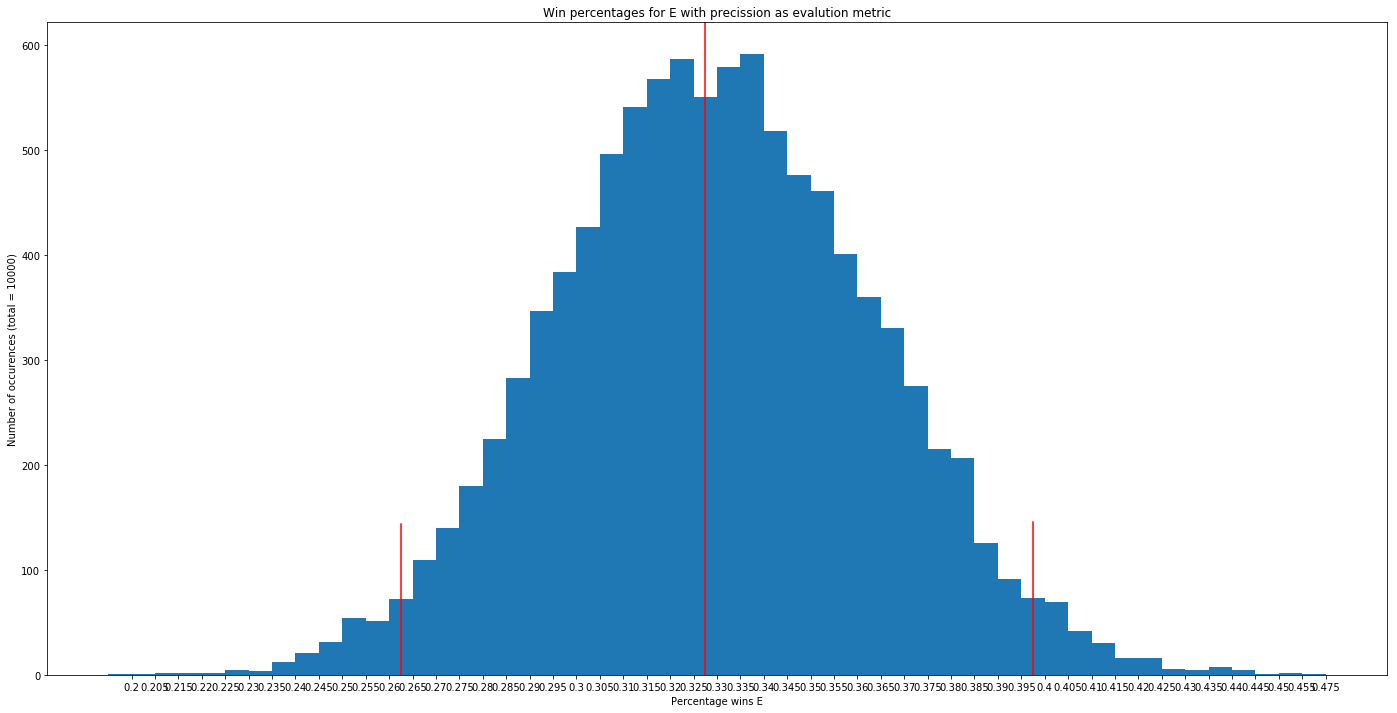

95.0 confidence interval: 26.5% and 40.0%, with mean at 0.332


In [291]:
# Global confidence level
CONFIDENCE_LEVEL = 0.95

'''Histogram for the offline precision'''

low_precision, up_precision, mean_precision = plot_histogram_with_confidence(bootstrapping_data['offline_wins']['precision'], 
                                                                           CONFIDENCE_LEVEL, 
                                                                           'Win percentages for E with precission as evalution metric')

print('%.1f confidence interval: %.1f%% and %.1f%%, with mean at %.3f' % (CONFIDENCE_LEVEL*100, low_precision*100, up_precision*100, mean_precision))



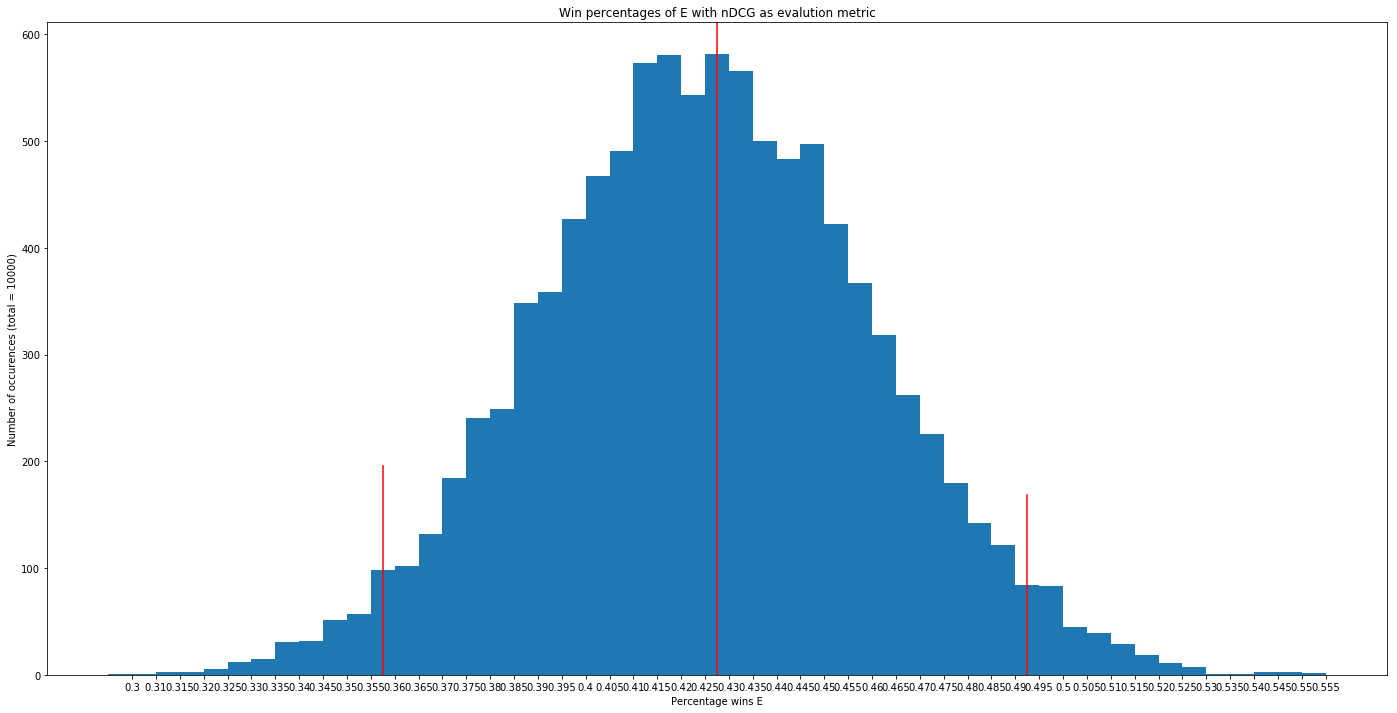

95.0 confidence interval: 36.0% and 49.5%, with mean at 0.428


In [292]:
'''Histogram for the offline normalized discounted cumulative gain'''

low_nDCG, up_nDCG, mean_nDCG = plot_histogram_with_confidence(bootstrapping_data['offline_wins']['dcg'], 
                                                                           CONFIDENCE_LEVEL, 
                                                                           'Win percentages of E with nDCG as evalution metric')

print('%.1f confidence interval: %.1f%% and %.1f%%, with mean at %.3f' % (CONFIDENCE_LEVEL*100, low_nDCG*100, up_nDCG*100, mean_nDCG))

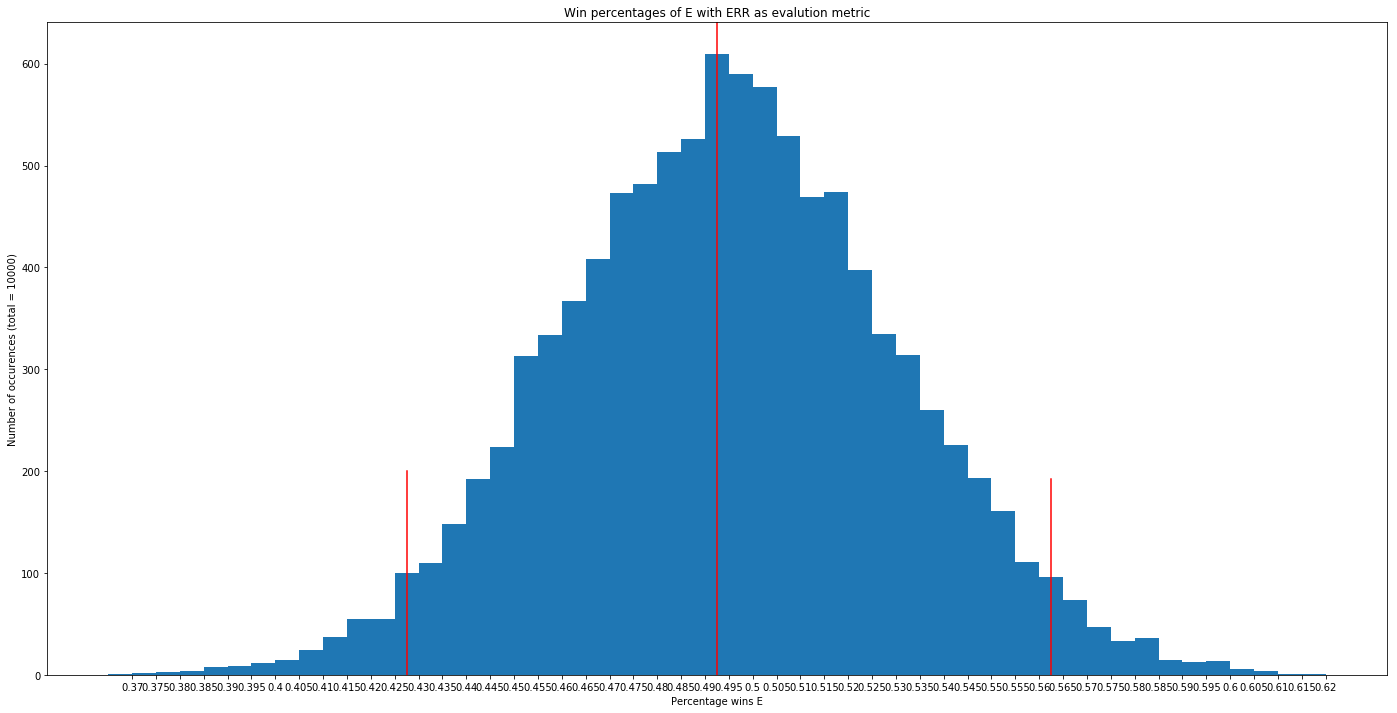

95.0 confidence interval: 43.0% and 56.5%, with mean at 0.497


In [293]:
'''Histogram for the offline Expected Reciprocal Rank'''

low_ERR, up_ERR, mean_ERR = plot_histogram_with_confidence(bootstrapping_data['offline_wins']['err'], 
                                                                           CONFIDENCE_LEVEL, 
                                                                           'Win percentages of E with ERR as evalution metric')

print('%.1f confidence interval: %.1f%% and %.1f%%, with mean at %.3f' % (CONFIDENCE_LEVEL*100, low_ERR*100, up_ERR*100, mean_ERR))

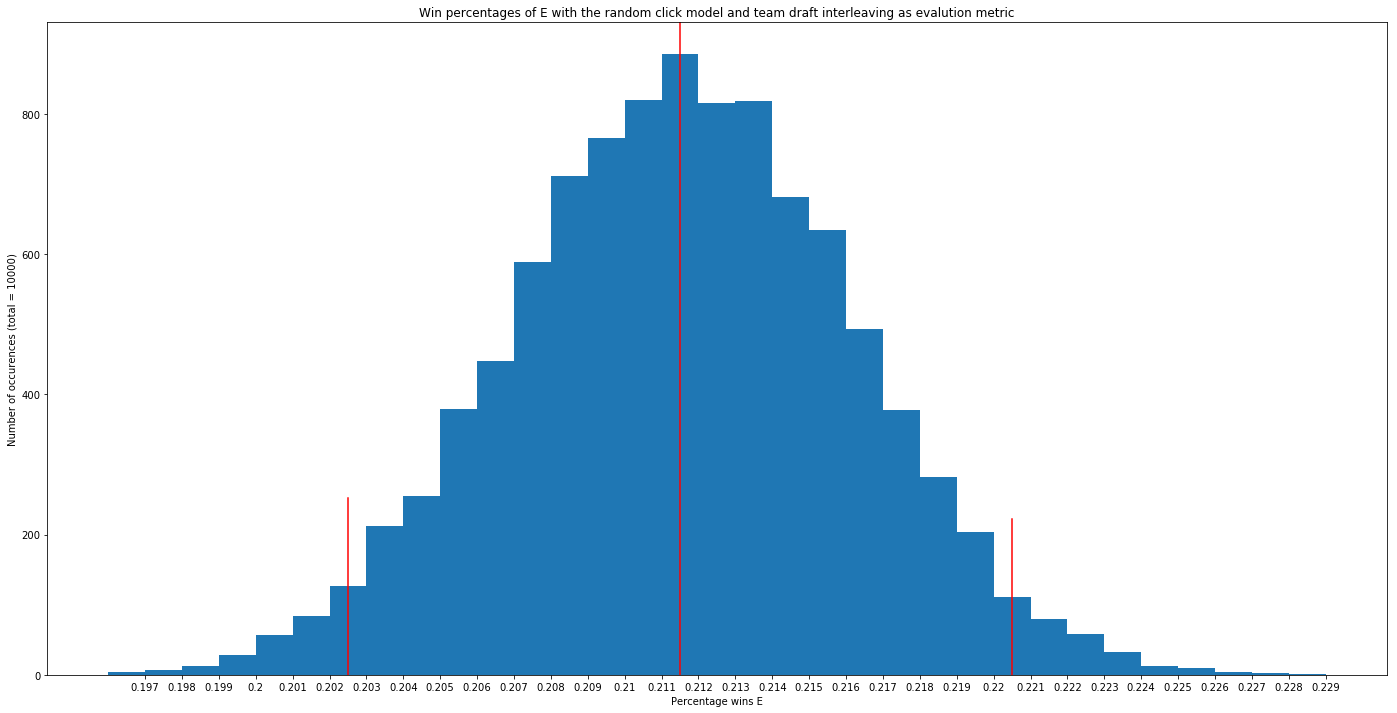

95.0 confidence interval: 20.3% and 22.1%, with mean at 0.212


In [294]:
'''Histogram for interleaving with the random click model'''

low_random, up_random, mean_random = plot_histogram_with_confidence(bootstrapping_data['team']['wins_random'], 
                                                                           CONFIDENCE_LEVEL, 
                                                                           'Win percentages of E with the random click model and team draft interleaving as evalution metric',
                                                                           random=True)

print('%.1f confidence interval: %.1f%% and %.1f%%, with mean at %.3f' % (CONFIDENCE_LEVEL*100, low_random*100, up_random*100, mean_random))

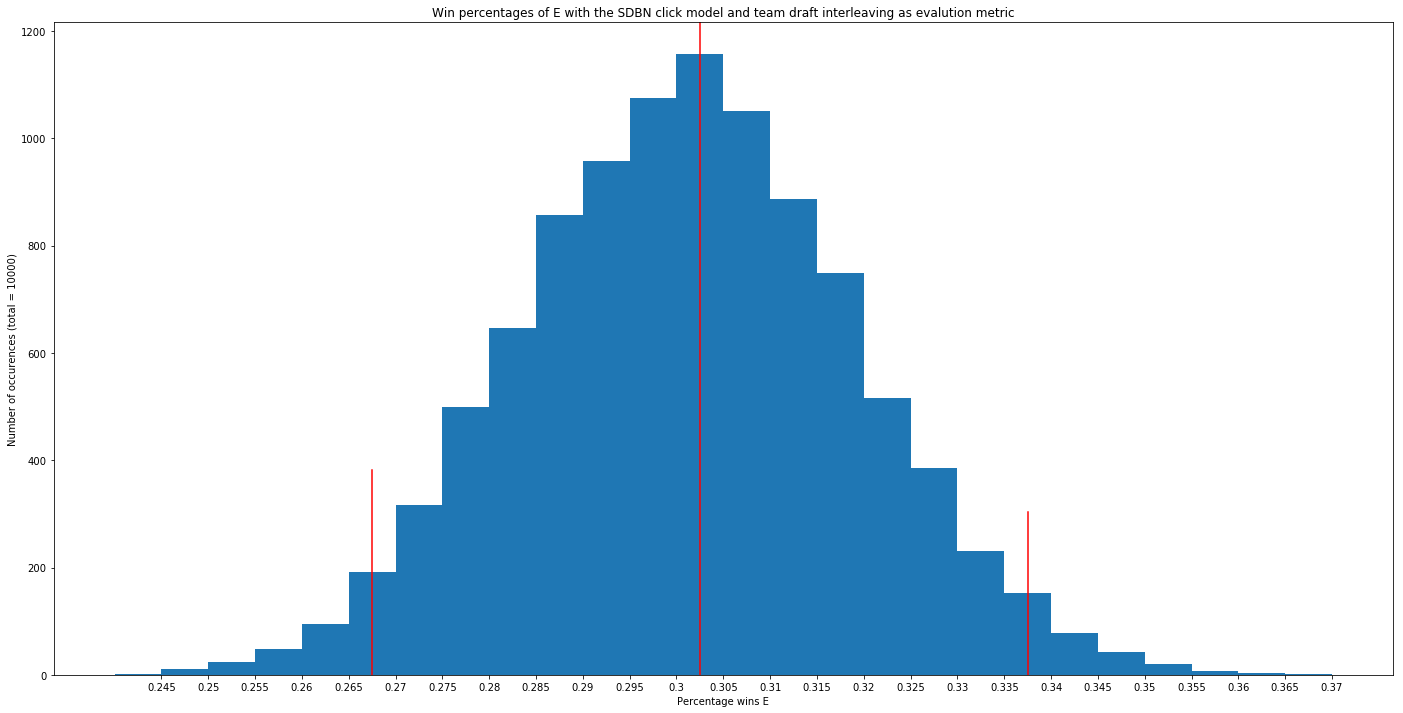

95.0 confidence interval: 27.0% and 34.0%, with mean at 0.304


In [295]:
low_sdbn, up_sdbn, mean_sdbn = plot_histogram_with_confidence(bootstrapping_data['team']['wins_sdbn'], 
                                                                           CONFIDENCE_LEVEL, 
                                                                           'Win percentages of E with the SDBN click model and team draft interleaving as evalution metric')

print('%.1f confidence interval: %.1f%% and %.1f%%, with mean at %.3f' % (CONFIDENCE_LEVEL*100, low_sdbn*100, up_sdbn*100, mean_sdbn))

### Analyses plots and confidence intervals

% B

### Mean testing
To be able to do a t-test we must first confirm that the data follows a normal distribution. For this purpose the Omnibus test by D'agostino and Pearson is used (D’Agostino, R. and Pearson, E. S. (1973), “Testing for departures from normality,” Biometrika, 60, 613-622). The experimental data is generated with an N=100, meaning 100 experiments for all interleaved rankings per click model are simulated.



In [293]:
import random
import scipy.stats as stats

# Test if data is normaliy distributed
def normality_test(metric_data, metric_name):
    
    # Convert the counter to an array
    data = []
    dictkeys = metric_data.keys()
    dictcounts = metric_data.values() 
    for i in range(len(metric_data)):
        data.extend([list(dictkeys)[i] for x in range(list(dictcounts)[i])])
    
    data=sorted(data)
    if stats.normaltest(data, axis=0)[1] < 0.05:
        print('The p-value for the normality test of the win percentages of %s is %.3f. This means that the win percentages are not normally distributed and a t-test cannot be performed'%(metric_name, stats.normaltest(data, axis=0)[1]))
    
    else:
        print('The p-value for the normality test of the win percentages of %s is %.3f. This means that the win percentages are normally distributed and a t-test can be performed'%(metric_name, stats.normaltest(data, axis=0)[1]))
    
    return
    
    
# print(bootstrapping_data['team']['wins_sdbn'])
# # print(len(bootstrapping_data['team']['wins_sdbn']))
# print(bootstrapping_data['team']['wins_sdbn'].keys())
# print(bootstrapping_data['team']['wins_sdbn'].values())
normality_test(bootstrapping_data['team']['wins_sdbn'],'SDBN')

The p-value for the normality test of the win percentages of SDBN is 0.018. This means that the win percentages are not normally distributed and a t-test cannot be performed


In [ ]:
metrics = [bootstrapping_data['team']['wins_sdbn'],bootstrapping_data['team']['wins_sdbn']]
for metric in metrics:
    normality_test(metric_data, metric_name)